In [1]:
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection
from progressbar import progressbar
import torch

In [2]:
pd.options.display.float_format = '{:.6f}'.format

In [3]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y, X = y.astype(np.int64), X.reshape(-1, 784).astype(np.float32)
X[X < 128] = 0
X[X > 0] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=47)

# Without Dropout

In [4]:
EPOCHS=400
BATCH_SIZE=128

accuracy = lambda prediction, target: np.sum(np.argmax(prediction, axis=1) == target) / target.shape[0]
lossFn = torch.nn.CrossEntropyLoss()

first_layer = torch.nn.Linear(784, 21)
second_layer = torch.nn.Linear(21, 10)
model = torch.nn.Sequential(
    first_layer,
    torch.nn.Tanh(),
    second_layer,
    torch.nn.Softmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters())

In [5]:
without_losses = []
for epoch in progressbar(range(EPOCHS)):
    loss_agg = 0
    order = np.random.permutation(train_data.shape[0])
    train_x = train_data[order]
    train_y = train_target[order]
    for i in range(0, train_x.shape[0] // BATCH_SIZE):
        batch_x = train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch_y = train_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

        optimizer.zero_grad()
        output = model(torch.from_numpy(batch_x))
        loss = lossFn(output, torch.from_numpy(batch_y))
        loss.backward()
        optimizer.step()
        loss_agg += loss.item()
    without_losses += [loss_agg]

100% (1000 of 1000) |####################| Elapsed Time: 0:14:02 Time:  0:14:020708


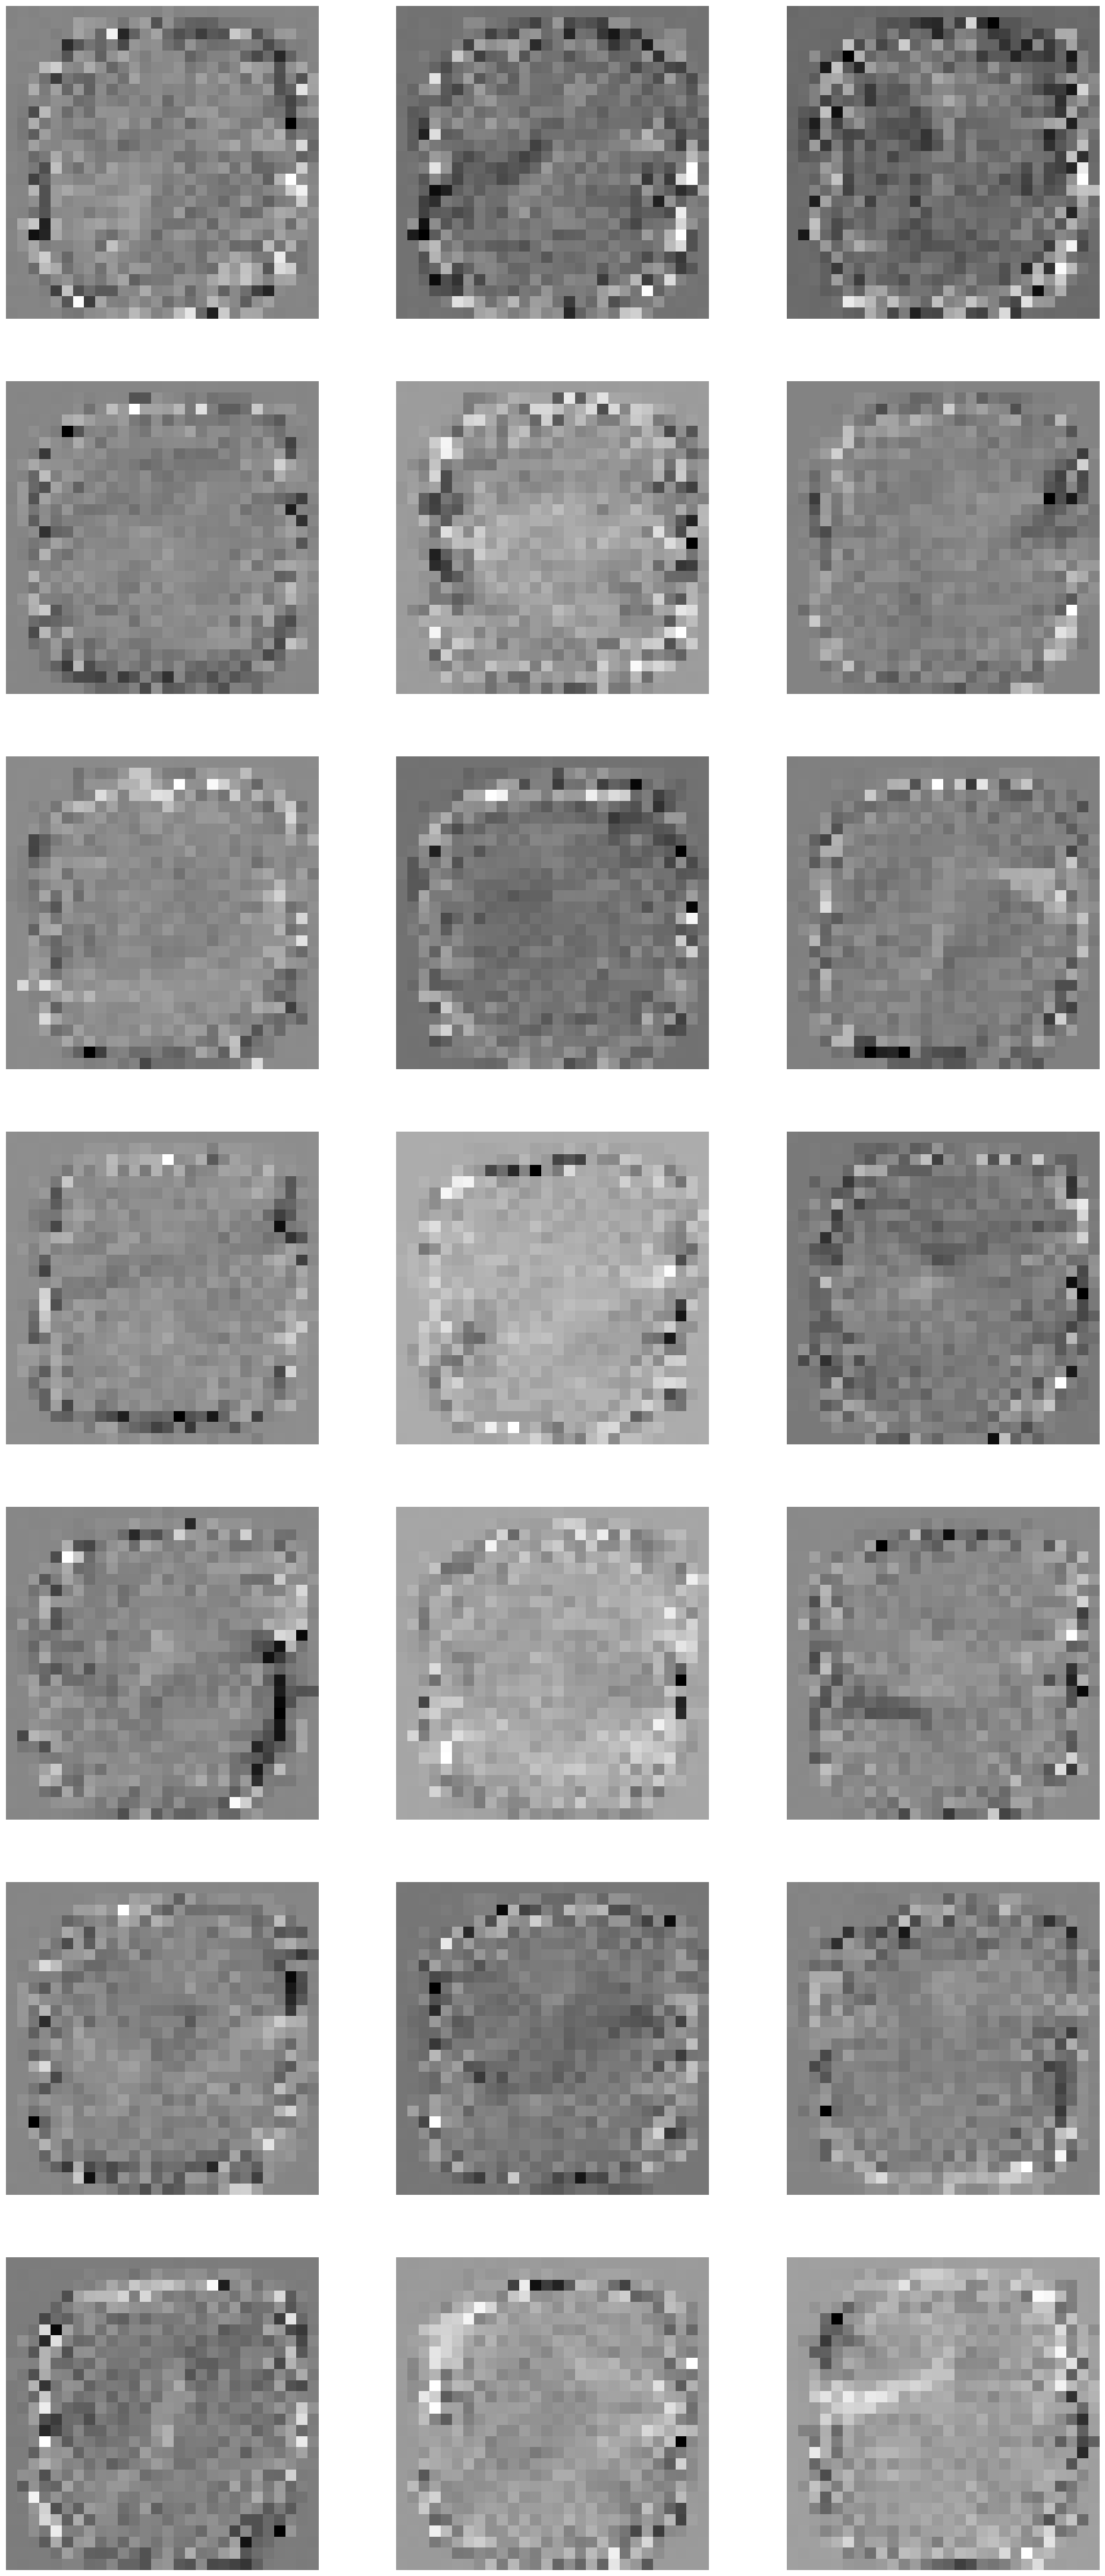

In [6]:
fig = plt.figure(figsize=(8 * 3, 8 * first_layer.weight.shape[0] // 3))
axes = fig.subplots(first_layer.weight.shape[0] // 3, 3)
for i, weights in enumerate(first_layer.weight.detach().numpy()):
    axes[i // 3][i % 3].imshow(weights.reshape((28,28)), cmap='binary')
    for ax in axes[i // 3]:
        ax.axis('off')

# With dropout

In [7]:
EPOCHS=400
BATCH_SIZE=128

accuracy = lambda prediction, target: np.sum(np.argmax(prediction, axis=1) == target) / target.shape[0]
lossFn = torch.nn.CrossEntropyLoss()

first_layer = torch.nn.Linear(784, 21)
second_layer = torch.nn.Linear(21, 10)
model = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    first_layer,
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    second_layer,
    torch.nn.Softmax(dim=1)
)

optimizer = torch.optim.Adam(model.parameters())

In [8]:
with_losses = []
for epoch in progressbar(range(EPOCHS)):
    loss_agg = 0
    order = np.random.permutation(train_data.shape[0])
    train_x = train_data[order]
    train_y = train_target[order]
    for i in range(0, train_x.shape[0] // BATCH_SIZE):
        batch_x = train_x[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch_y = train_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

        optimizer.zero_grad()
        output = model(torch.from_numpy(batch_x))
        loss = lossFn(output, torch.from_numpy(batch_y))
        loss.backward()
        optimizer.step()
        loss_agg += loss.item()
    with_losses += [loss_agg]

100% (1000 of 1000) |####################| Elapsed Time: 0:16:45 Time:  0:16:450921


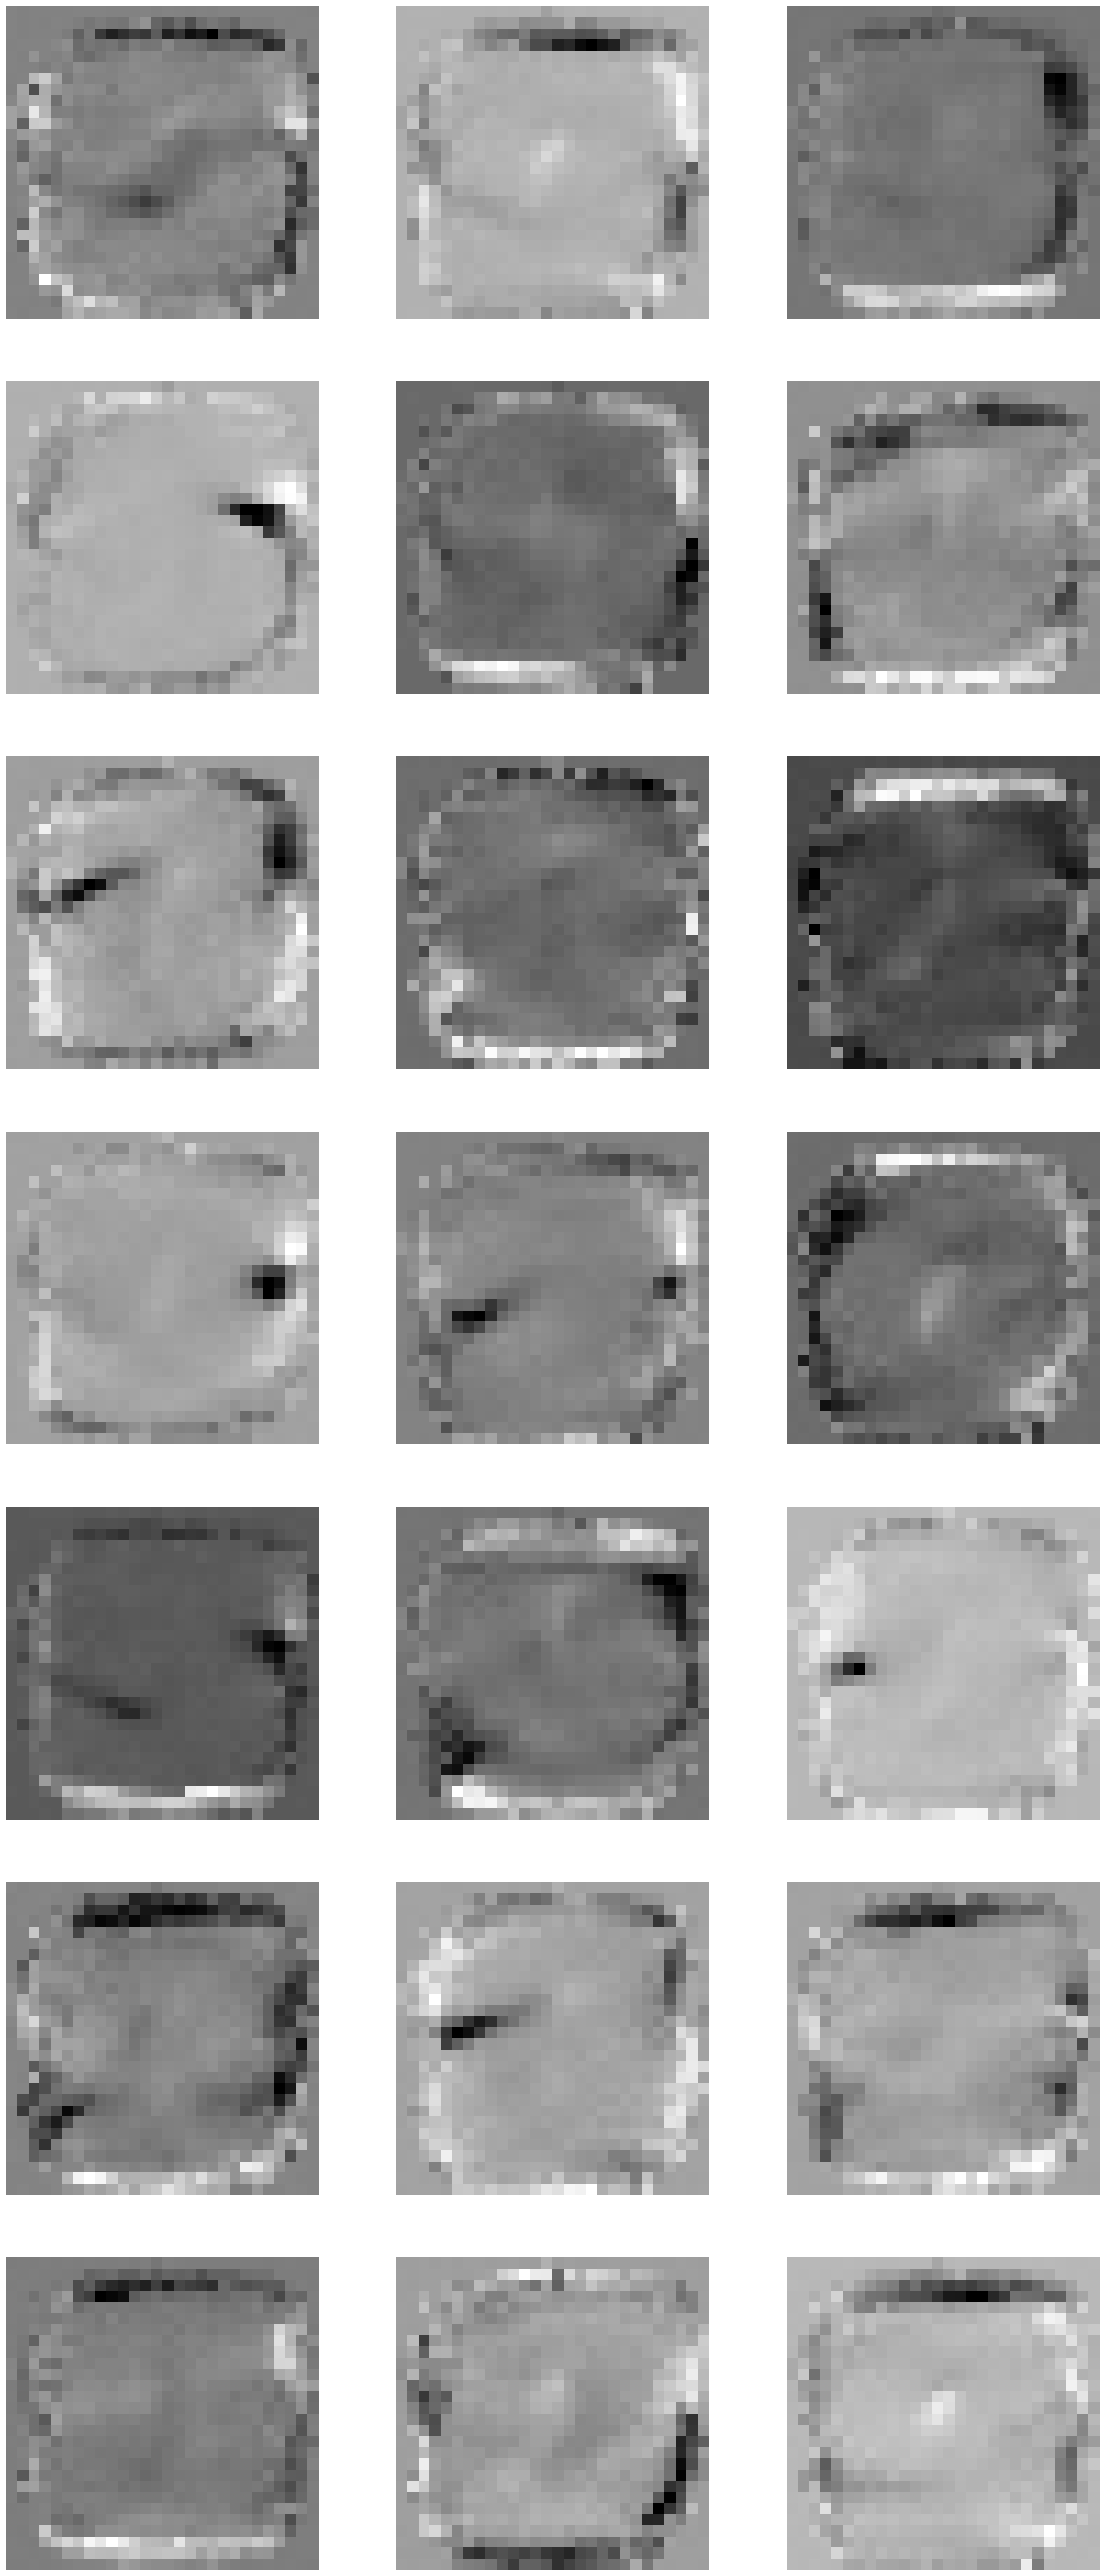

In [9]:
fig = plt.figure(figsize=(8 * 3, 8 * first_layer.weight.shape[0] // 3))
axes = fig.subplots(first_layer.weight.shape[0] // 3, 3)
for i, weights in enumerate(first_layer.weight.detach().numpy()):
    axes[i // 3][i % 3].imshow(weights.reshape((28,28)), cmap='binary')
    for ax in axes[i // 3]:
        ax.axis('off')

# Results

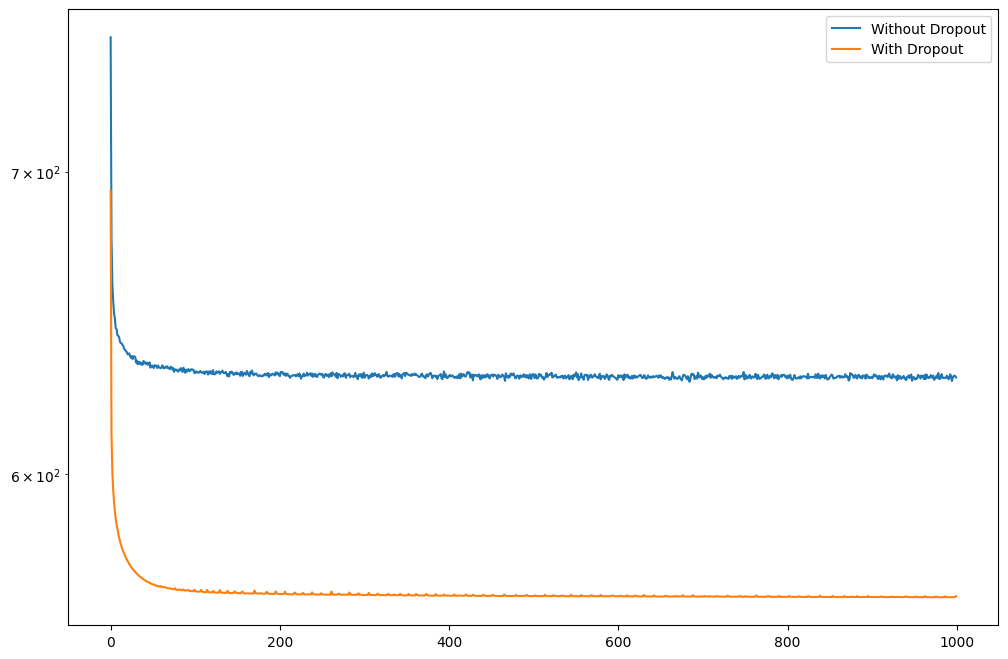

In [10]:
plt.figure(figsize=(12,8))
plt.plot(with_losses, label='Without Dropout')
plt.plot(without_losses, label='With Dropout')
plt.yscale('log')
plt.legend()
plt.show()